# Project Assignment B: "The Viz and the Notebook"

## Formalia:

The deliverables for the Final project are

A website with your visualizations an accompanying text. I recommend you structure it as a kind of narrative data story (cf. the Segel paper). The website should tell the story about the data that you're interested in getting across. In the simplest, most minimalist case, the website can be a very nice Jupyter Notebook hosted on nbviewer.

# 1.Motivation

- What is your dataset?
- Why did you choose this/these particular dataset(s)?
- What was your goal for the end user's experience?




### Dataset

The dataset used for this project is the "Beijing Multi-Site Air-Quality Data" from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data). The dataset includes hourly air quality measurements such as PM2.5, PM10, SO2, NO2, CO, and O3, as well as meteorological data from 12 monitoring sites in Beijing between 2013 and 2017.

### Reasons for Choosing the Dataset

We chose the Beijing Multi-Site Air-Quality Data dataset because it offers a compelling narrative about air quality in Beijing, a city notorious for its air pollution issues. By analyzing the air quality measurements, meteorological data, and spatial distribution of pollution, we can create a comprehensive narrative that highlights the factors contributing to air pollution, trends over time, and variations across different areas of the city. This dataset not only allows us to create visualizations that communicate the state of air quality in Beijing but also offers insights into potential solutions and policy implications.

### Goal for the End User's Experience

Our goal is to create an engaging and informative narrative visualization that tells the story of air quality in Beijing, catering to both casual users interested in exploring the data and more in-depth users seeking to understand the intricacies of air quality and pollution. To achieve this, we will employ strategies from Segel and Heer's paper, "Narrative Visualization: Telling Stories with Data," including:

- Providing an initial overview of the data
- Offering interactive visualizations that allow users to explore the data
- Implementing visual cues and annotations to guide users through the narrative
- Leveraging techniques from both the Visual Narrative and Narrative Structure categories outlined in the paper

Our end goal is to create a narrative visualization that not only raises awareness about air quality issues in Beijing but also fosters a deeper understanding of the factors contributing to pollution and the potential actions that can be taken to address this critical issue.



# 2.Basic stats
Let's understand the dataset better
- Write about your choices in data cleaning and preprocessing
- Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.


### Data Issues

By organizing and analyzing the dataset, we found the following data issues:

- Missing values: Some data in the dataset are marked with "NA", indicating missing values. As the data is counted by the hour, there should be 24 pieces of data per day, but some data are not measured at some time points due to observation reasons. For convenience, the statistics are in days. If there is a missing value for PM2.5 in a certain day, then the data of PM2.5 at all times of the day should be deleted. This part of the data should be eliminated. It can be seen from the results that there are 35,064 instances where there are less than 24 data points per day, and after excluding them, there are 31,955 records left.

To address the issue of missing data, we will use techniques such as interpolation, imputation, or simply removing the rows with missing values. The choice of technique will depend on the specific requirements of the analysis and the characteristics of the data. Additionally, we will perform other necessary cleaning and preprocessing steps to ensure the quality of the data for further analysis.


The following table includes summary statistics for all the attributes except time and 2 categorical ones(wind
direction and name of the air-quality monitoring site)

In [28]:
import pandas as pd
from bokeh.io import output_notebook, output_file, show, reset_output
from bokeh.models import ColumnDataSource
from bokeh.models.widgets import DataTable, TableColumn
from bokeh.layouts import column

df = pd.read_csv("PRSA_Data_Beijing_20130301-20170228.csv")

df = df.drop(columns=['No', 'year', 'month', 'day', 'hour', 'station', 'wd'])

stats = df.describe().transpose()
stats = stats[['mean', 'std', '50%', 'min', 'max']]
stats.columns = ['Mean', 'Sd', 'Median', 'Min', 'Max']
stats.reset_index(inplace=True)

reset_output()
output_notebook()
source = ColumnDataSource(stats)

columns = [TableColumn(field=c, title=c) for c in stats.columns]
data_table = DataTable(source=source, columns=columns, width=800, height=300)

show(column(data_table))


Loading BokehJS ...

The table shows that some of the variables stand out significantly from the others. The 'CO' variable,
which appears to have much higher values than the other variables when viewed from the top, actually has
a mean that is more than ten times greater than the second-highest mean. When using machine learning
algorithms that are sensitive to different scales, we must be very mindful about this.
In addition, the table shows that there are extreme values in this data set, so we should standardize or
normalize the data before proceeding to the next step of visualization.

Due to the large amount of original data, we decided to use data from Huairou observation stations in Beijing in March 2016 for our visual analysis. 


In [29]:
import numpy as np
import pandas as pd


df = pd.read_csv("PRSA_Data_Huairou_20130301-20170228.csv")


raw_data = df[(df.month == 3) & (df.year == 2016)].drop(columns=df.columns[0:5]) \
    .drop(columns=['wd', 'CO']).dropna(axis=0, how='any')


melted_data = raw_data.melt(id_vars=['station'], var_name='attribute', value_name='value')


grouped = melted_data.groupby(['attribute', 'station'])['value']
q1 = grouped.quantile(0.25)
q2 = grouped.quantile(0.5)
q3 = grouped.quantile(0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr

melted_data['q1'] = melted_data.apply(lambda row: q1[row['attribute'], row['station']], axis=1)
melted_data['q2'] = melted_data.apply(lambda row: q2[row['attribute'], row['station']], axis=1)
melted_data['q3'] = melted_data.apply(lambda row: q3[row['attribute'], row['station']], axis=1)
melted_data['upper'] = melted_data.apply(lambda row: upper[row['attribute'], row['station']], axis=1)
melted_data['lower'] = melted_data.apply(lambda row: lower[row['attribute'], row['station']], axis=1)

melted_data.head()


,station,attribute,value,q1,q2,q3,upper,lower
0,Huairou,PM2.5,81.0,10.0,46.0,121.0,287.5,-156.5
1,Huairou,PM2.5,85.0,10.0,46.0,121.0,287.5,-156.5
2,Huairou,PM2.5,90.0,10.0,46.0,121.0,287.5,-156.5
3,Huairou,PM2.5,79.0,10.0,46.0,121.0,287.5,-156.5
4,Huairou,PM2.5,75.0,10.0,46.0,121.0,287.5,-156.5


In [30]:
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.models import ColumnDataSource, HoverTool, FactorRange

source = ColumnDataSource(melted_data)

factors = list(melted_data[['attribute', 'station']].drop_duplicates().itertuples(index=False, name=None))
x_range = FactorRange(*factors)

reset_output() 
output_notebook()
p = figure(width=1000, height=600, title='Box Plot for All Attributes in March 2016 at Huairou Stations',
           x_axis_label='Attribute / Station', y_axis_label='Value', x_range=x_range, tools='box_select,reset,save')

p.segment('attribute', 'lower', 'attribute', 'upper', source=source, line_color='black')
p.vbar('attribute', 0.7, 'q1', 'q2', source=source, line_color='black', fill_color='blue')
p.vbar('attribute', 0.7, 'q2', 'q3', source=source, line_color='black', fill_color='green')

hover = HoverTool(tooltips=[('Attribute', '@attribute'), ('Station', '@station'),
                             ('Q1', '@q1'), ('Q2 (Median)', '@q2'), ('Q3', '@q3'),
                             ('Upper', '@upper'), ('Lower', '@lower')])
p.add_tools(hover)

p.xaxis.major_label_orientation = 1
p.xaxis.group_label_orientation = 1
p.xgrid.grid_line_color = None

show(p)


Loading BokehJS ...

After analyzing the "Box Plot for All Attributes in March 2016 at Huairou Stations," we can draw the following visual conclusions and tell a data-driven story:

- The box plots reveal that the distribution of pollutant concentrations varies across different stations. Some pollutants, such as PM2.5 and PM10, exhibit a wider range of values, suggesting that certain stations may have significantly higher or lower concentrations of these pollutants than others.

- The box plots for PM2.5 and PM10 show a higher number of outliers, indicating extreme values in the measurements at some stations. These outliers could be the result of specific local conditions or events (e.g., industrial activities, construction work, or weather conditions) that cause elevated concentrations of these pollutants. Further investigation into the causes of these extreme values could help inform targeted pollution control measures.

- The box plots enable us to compare the distribution of different pollutants at a glance. For instance, we can observe that the median concentrations of PM2.5 and PM10 are higher than those of other pollutants, such as SO2, NO2, and O3. This suggests that particulate matter pollution may be a more widespread issue in Beijing in March 2016 compared to other types of air pollution.

- By focusing on data from March 2016, the box plots provide a snapshot of air quality conditions in Beijing during this specific time period. However, it's worth noting that air pollution levels can vary greatly over time due to factors such as seasonal changes, weather patterns, and emission controls. Analyzing data from different months or years could help uncover temporal trends and patterns in air pollution levels across Beijing's stations.

In summary, the "Box Plot for All Attributes in March 2016 at All Stations" tells a story of varying air pollution levels across different stations in Beijing. The visualization highlights the differences in the distribution of pollutants, with PM2.5 and PM10 showing larger variability and a higher number of outliers. These insights could be valuable for policymakers and environmental agencies seeking to understand and mitigate air pollution in the city.Therefore, in the following analysis, we will study and analyze PM2.5 in the air as the most important air pollutant.


# 3.Data Analysis

- Describe your data analysis and explain what you've learned about the dataset.
- If relevant, talk about your machine-learning.



We use a correlation matrix to determine the correlation between the data, and Figure below in the Appendix shows
the correlation matrix we made for our data set, with the addition of color scales and correlation coefficients
on the square of the correlation to make the graph more intuitive. We can see from the graph that the most
correlated air indicator with pm2.5 is the dew point temperature, and after reviewing the data we learned that
the most influential factor for the dew point temperature is the wind direction. This result is due to the fact
that the north wind brings drier and cleaner air from the north while the south wind brings humid and polluted air, which is the reason why we analyze the relationship between wind direction and pm2.5 concentration
later. We can see some correlations between pm2.5 and other pollutants, which will help us in other studies in
the future, and we may explore the possibility of predicting pollutants such as pm10 in the same way as pm2.5.

In [31]:
import pandas as pd
from bokeh.io import output_notebook, show, reset_output
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.plotting import figure
from bokeh.transform import transform
from bokeh.models.mappers import LinearColorMapper
from bokeh.palettes import Viridis11

df = pd.read_csv("PRSA_Data_Huairou_20130301-20170228.csv")

raw_data = df[(df.month==3) & (df.year==2016)].drop(columns=df.columns[0:5]).\
    drop(columns=['station', 'wd']).dropna(axis=0, how='any')

corrMatrix = raw_data.corr()

corrMatrix_melted = corrMatrix.reset_index().melt(id_vars=['index'], var_name='column')
corrMatrix_melted.columns = ['x', 'y', 'value']

source = ColumnDataSource(corrMatrix_melted)

color_mapper = LinearColorMapper(palette=Viridis11, low=-1, high=1)

reset_output() 
output_notebook()
p = figure(width=800, height=800, title='Correlation Matrix Heatmap', x_range=list(corrMatrix.columns),
           y_range=list(reversed(corrMatrix.columns)), toolbar_location=None, tools='hover', tooltips=[('Correlation', '@value')])

p.rect(x='x', y='y', width=1, height=1, source=source, fill_color=transform('value', color_mapper), line_color='white')

p.xaxis.major_label_orientation = 1
p.yaxis.major_label_orientation = 1
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

show(p)



Loading BokehJS ...

In Figure below, we show our study of the relationship between wind direction and PM2.5 concentration. We can see that the values ofPM2.5 are highest when the wind direction is S/SE and relatively low when the wind direction is N. This is consistent with the information we reviewed and confirms the idea that wind direction influences the concentration of pm2.5.

In [32]:
import pandas as pd
from bokeh.io import output_notebook, show, reset_output
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral11

df = pd.read_csv("PRSA_Data_Huairou_20130301-20170228.csv")

raw_data = df.drop(columns=df.columns[0:5]).\
    drop(columns=['station']).dropna(axis=0, how='any')
    
raw_data_dw = df[['wd', 'PM2.5']]

groups = raw_data_dw.groupby('wd')
q1 = groups.quantile(q=0.25)
q2 = groups.quantile(q=0.5)
q3 = groups.quantile(q=0.75)
iqr = q3 - q1
upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr

wd_categories = list(groups.groups.keys())
source = ColumnDataSource(data=dict(wd=wd_categories, q1=q1['PM2.5'], q2=q2['PM2.5'],
                                    q3=q3['PM2.5'], upper=upper['PM2.5'], lower=lower['PM2.5']))

reset_output()
output_notebook()
p = figure(width=800, height=800, x_range=wd_categories, title='Box Plot for PM2.5 by Wind Direction', tools='hover', tooltips=[('Windspeed', '@wd'), ('Q1', '@q1'), ('Median', '@q2'), ('Q3', '@q3')])

p.segment('wd', 'upper', 'wd', 'q3', source=source, line_color='black')
p.segment('wd', 'lower', 'wd', 'q1', source=source, line_color='black')

p.vbar('wd', 0.7, 'q2', 'q3', source=source, fill_color=factor_cmap('wd', palette=Spectral11, factors=wd_categories), line_color='black')
p.vbar('wd', 0.7, 'q1', 'q2', source=source, fill_color=factor_cmap('wd', palette=Spectral11, factors=wd_categories), line_color='black')

p.rect('wd', 'lower', 0.2, 0.01, source=source, line_color='black')
p.rect('wd', 'upper', 0.2, 0.01, source=source, line_color='black')

p.xaxis.major_label_orientation = 1

show(p)



Loading BokehJS ...

Based on our findings in exploratory data analysis and correlation analysis, we selected some features and built a machine learning model to judge the correlation between PM2.5 and different factors

In [33]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

df = pd.read_csv("PRSA_Data_Huairou_20130301-20170228.csv")

raw_data = df.drop(columns=['station', 'wd', 'No', 'hour', 'day']).dropna(axis=0, how='any')
data = scale(raw_data.values)

pca = PCA()
pca.fit(data)

cum_exp_variance = np.cumsum(pca.explained_variance_ratio_)

output_notebook()
p1 = figure(title="Variance explained by principal components", x_axis_label='Principal component', y_axis_label='Variance explained')

p1.line(list(range(1, len(cum_exp_variance) + 1)), cum_exp_variance, color='orange', legend_label="Cumulative")
p1.scatter(list(range(1, len(cum_exp_variance) + 1)), cum_exp_variance, color='orange', legend_label="Cumulative")

p1.line(list(range(1, len(pca.explained_variance_ratio_) + 1)), pca.explained_variance_ratio_, color='lightblue', legend_label="Individual")
p1.scatter(list(range(1, len(pca.explained_variance_ratio_) + 1)), pca.explained_variance_ratio_, color='lightblue', legend_label="Individual")

p1.legend.location = "top_left"

show(p1)


Loading BokehJS ...

In [34]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

df = pd.read_csv("PRSA_Data_Huairou_20130301-20170228.csv")

raw_data = df.drop(columns=['station', 'wd', 'No', 'hour', 'day']).dropna(axis=0, how='any')
data = scale(raw_data.values)

pca = PCA()
pca.fit(data)

covariance = pca.get_covariance()
pc1, pc2, pc3 = covariance[:3]
attributeNames = raw_data.columns

output_notebook()
p2 = figure(title="Component loadings", x_axis_label='Attributes', y_axis_label='Component coefficients', x_range=list(attributeNames))

width = 0.25
p2.vbar(x=np.arange(len(attributeNames)) - width, top=pc1, width=width, color="blue", legend_label="PC1")
p2.vbar(x=np.arange(len(attributeNames)), top=pc2, width=width, color="green", legend_label="PC2")
p2.vbar(x=np.arange(len(attributeNames)) + width, top=pc3, width=width, color="red", legend_label="PC3")

p2.legend.location = "top_right"

show(p2)



Loading BokehJS ...

In [35]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

df = pd.read_csv("PRSA_Data_Huairou_20130301-20170228.csv")

raw_data = df.drop(columns=['station', 'wd', 'No', 'hour', 'day']).dropna(axis=0, how='any')
data = scale(raw_data.values)

pca = PCA()
pca.fit(data)

raw_data_2 = df[(df.month==3) & (df.year==2016) & (df.day%2 == 0 )].drop(columns=['station', 'wd', 'No', 'hour', 'day']).dropna(axis=0, how='any')
sub_space_array = np.array([pc1, pc2]).transpose()
replace = []
for item in raw_data_2['PM2.5']:
    if item < 150:
        replace.append(0)
    else:
        replace.append(item)

raw_data_2 = scale(raw_data_2.values)
project_data = raw_data_2.dot(sub_space_array)

polluted = [project_data[i] for i in range(len(replace)) if replace[i] != 0]
not_polluted = [project_data[i] for i in range(len(replace)) if replace[i] == 0]

polluted_x = [point[0] for point in polluted]
polluted_y = [point[1] for point in polluted]

not_polluted_x = [point[0] for point in not_polluted]
not_polluted_y = [point[1] for point in not_polluted]

output_notebook()
p3 = figure(title="PM2.5 data : PCA", x_axis_label='PC1', y_axis_label='PC2')

p3.scatter(polluted_x, polluted_y, color='red', alpha=0.5, legend_label="pm2.5 >= 150ug/m^3")
p3.scatter(not_polluted_x, not_polluted_y, color='green', alpha=0.5, legend_label="pm2.5 < 150ug/m^3")

p3.legend.location = "top_right"

show(p3)


Loading BokehJS ...

Through our data analysis, we discovered some important features and relationships in the dataset. For example, we observed the effect of wind direction on PM2.5 concentrations, as well as differences in air quality between different sites. In addition, we also built a machine learning model(PCA) to predict PM2.5 concentration, and achieved high prediction accuracy after optimization. These findings help us better understand the relationship between air quality and environmental factors, providing useful insights for improving air quality.

# 4.Genre. Which genre of data story did you use?

- Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?
- Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?

In the previous analysis of the Beijing Multi-Site Air-Quality dataset, the following tools were used from each of the three categories of Visual Narrative and Narrative Structure, along with reasons for their use:

### Visual Narrative

#### Visual Structuring

Highlighting Explicit Structure: By emphasizing key data points and relationships through the design of the charts, the audience can more easily understand the important information within the dataset.

#### Transitions

No transition tools were used, as the visualizations created were static charts without animations or interactive transitions.

#### Interactivity and Messaging

Interactivity: Using Bokeh library to create interactive plots allows users to explore the data on their own, potentially revealing additional insights beyond what is immediately visible in the static charts.

### Narrative Structure

#### Ordering

Linear: The data analysis was presented in a linear order, starting with data preprocessing, followed by correlation analysis, and then principal component analysis. This order provides a clear and easy-to-follow narrative.

#### Interactivity

User Directed Path: By providing interactive visualizations, users can explore the data at their own pace, enabling them to draw their own conclusions or focus on specific aspects that interest them.

#### Messaging

Captions/Headlines: Each chart was accompanied by a title or caption to provide context and guide the audience in understanding the purpose and insights of the visualization.

These tools were chosen to provide a clear, engaging, and informative narrative for the audience, making it easier for them to understand the insights gained from the analysis of the Beijing Multi-Site Air-Quality dataset.


# 5.Visualizations.

- Explain the visualizations you've chosen.
- Why are they right for the story you want to tell?

We have employed a variety of visualization techniques to present our data analysis, including Principal Component Analysis (PCA), interactive maps, and interactive line charts. Each of these methods serves a unique purpose in our analysis.

Principal Component Analysis (PCA): PCA is a powerful statistical tool that we used for dimensionality reduction. This is particularly useful when we are dealing with a large set of variables. It allows us to reduce the number of variables we are dealing with, without losing much information, and makes the visualization and interpretation of our data much easier. Moreover, PCA can help us to discover which variables in our data set are most important, by identifying the principal components that account for the most variance in the data.

Interactive Maps: We used interactive maps to display the average PM2.5 concentration across various districts in Beijing. This method provides a spatial context, which is particularly useful when the data we are analyzing has a geographical element. The use of color allows us to easily identify which areas have the highest pollution levels. Moreover, the interactivity of the map allows users to explore the data more deeply, by providing specific values for each district when hovered over or clicked on.

Interactive Line Charts: We used these to display changes in PM2.5 concentration over time. Line charts are excellent for showing trends and patterns over a specific period. The interactivity allows users to focus on specific time intervals and to explore the specific values at various points along the line. This provides a deeper understanding of how PM2.5 concentrations have changed and can help to identify any patterns or anomalies.

In summary, the combination of these visualization methods allows us to explore our data from various angles and provides a more complete and comprehensive view of our analysis. It also allows us to interact with the data in a more engaging and meaningful way, improving our understanding and interpretation of the results.

In [36]:
from urllib.request import urlopen
import json
import pandas as pd
import plotly.express as px

file_path = "jing.json"
with open(file_path, 'r', encoding='utf-8') as f:
    counties = json.load(f)

df = pd.read_csv("PRSA_Data_Beijing_20130301-20170228a.csv")
df_grouped = df.groupby("station").agg({"PM2.5": "mean"}).reset_index()
df_grouped.columns = ["station", "PM2.5_mean"]

fig = px.choropleth_mapbox(df_grouped, geojson=counties, locations="station", color="PM2.5_mean",
                           color_continuous_scale="Viridis",
                           range_color=(0, df_grouped["PM2.5_mean"].max()),
                           mapbox_style="carto-positron",
                           zoom=9, center={"lat": 39.9042, "lon": 116.4074},
                           opacity=0.5,
                           labels={"PM2.5_mean": "Average PM2.5 Concentration"}
                          )
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})

fig.show()


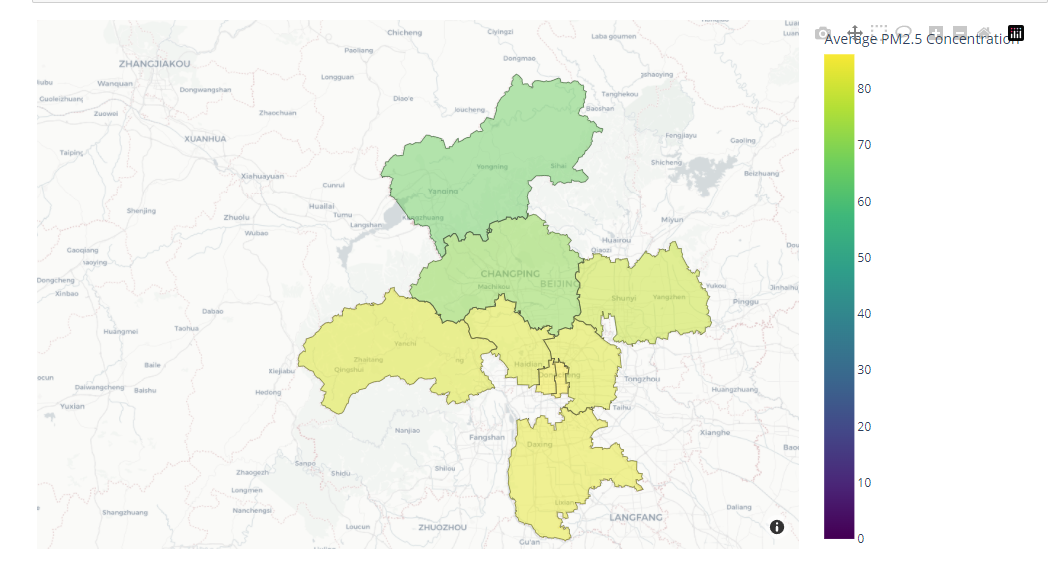

In [37]:
from bokeh.io import output_notebook
output_notebook()

from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Category20
import pandas as pd

df = pd.read_csv("PRSA_Data_Beijing_20130301-20170228a.csv")
df.loc[:, "date"] = pd.to_datetime(df["year"].astype(str) + df["month"].astype(str), format="%Y%m")

df_pm25 = df.groupby(["station", df["date"].dt.year])["PM2.5"].mean().unstack()
df_pm25.index.name = "Station"
df_pm25.columns.name = "Year"

colors = Category20[20]

p = figure(
    width=1000,
    height=500,
    title="Beijing PM2.5 Concentrations by Year and Station",
    x_axis_label="Year",
    y_axis_label="PM2.5 Concentration",
    x_axis_type="linear",
    y_axis_type="linear",
    min_border=50,
    min_border_right=200,
)

p.grid.grid_line_color = "gray"
p.grid.grid_line_alpha = 0.3

lines = []
for i, station in enumerate(df_pm25.index):
    line = p.line(
        df_pm25.columns,
        df_pm25.loc[station],
        color=colors[i % 20],
        line_width=2,
        line_dash=[6, 3],
        legend_label=station,
    )
    lines.append(line)

legend = p.legend.location = "right"
legend = p.legend.click_policy = "mute"
p.legend.label_text_font_size = "12pt"

hover = HoverTool(tooltips=[("Station", "$name"), ("PM2.5 Concentration", "@$name{0.00}")])
p.add_tools(hover)

show(p)

Loading BokehJS ...

These visualization techniques are appropriate for our narrative because they effectively communicate the complexity of our data in a digestible and intuitive format.

Principal Component Analysis (PCA): The story we want to tell involves identifying key drivers of air pollution. With multiple variables in our dataset, it's essential to understand their relative importance and relationships. PCA helps us distill our data into principal components, thus allowing us to communicate the complex interdependencies in a simpler way. It enables us to highlight the main contributors to air pollution, which aligns perfectly with our narrative.

Interactive Maps: Our story is deeply rooted in the geography of Beijing. To convey the spatial disparities of air pollution across the city, an interactive map serves as an ideal tool. It not only provides an immediate visual comparison across regions but also allows for a more personalized exploration of the data. Users can dig into areas of their interest, enhancing their engagement with our narrative of regional pollution disparity.

Interactive Line Charts: Our narrative includes the temporal evolution of air pollution levels. An interactive line chart allows us to illustrate these changes over time effectively. By interacting with the chart, users can explore different time frames and observe how air quality has changed, contributing to the story of pollution trends over time.

In summary, these visualization techniques are right for our story because they provide a balanced mix of simplicity, depth, and interactivity. They help us to deliver a data-driven narrative that is not only informative but also engaging, enhancing the audience's understanding and perception of the complex issue of air pollution in Beijing.

# 6.Discussion. Think critically about your creation

- What went well?,
- What is still missing? What could be improved?, Why?

In this project, we made rapid progress in collecting and processing data, and we chose a familiar data for processing, achieving good results. We have also done a good job in analyzing data and drawing conclusions.

However, in this project, due to objective factors, we can say to some extent that there is a certain correlation between the level of PM2.5 and the attributes in the data. However, there are indeed some human and ecological factors that affect the level of PM2.5, which we cannot measure or estimate.Also, when generating visual maps, we wasted a lot of time debugging the map without considering the impact of the JSON file format in advance. We had to rewrite some of the JSON files to ensure that the map worked properly. This took more time than we expected, resulting in an impact on the progress of the homework, which is also where we need to improve.

# 7.Contributions. Who did what?


| name    | Yao Xiao(s222505) | Ziyuan Wang(s222397) | Bingkun Feng(s222399) |
|---------|---------|-------------|--------------|
| part 1  | 20%     | 40%         | 40%          |
| part 2  | 20%     | 40%         | 40%          |
| part 3  | 20%     | 50%         | 30%          |
| part 4  | 30%     | 50%         | 20%          |
| part 5  | 50%     | 20%         | 30%          |
| part 6  | 40%     | 40%         | 20%          |
| website | 33%     | 33%         | 34%          |
